<a href="https://colab.research.google.com/github/Kaan-wq/ml_tokamak/blob/main/Event_NoEvent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import math
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
import os
import glob
import numpy as np
from typing import Iterable
import pickle
import tensorflow as tf
from keras.models import Model

import keras
import keras_tuner as kt
from kerastuner import RandomSearch
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers
from tensorflow.keras import regularizers

#**I - Preprocessing of the data**

Below is the preprocessing pipeline of the data. \\
Essentially, we feature engineer a few columns, normalize the data and finally, we split it into a training and testing set.

In [18]:
# load dataset using pickle
import pickle
with open("../data/dataset_disruption_characterization.pickle", "rb") as f:
    dataset = pickle.load(f)

Here we load the data from the drive and put it into a more practical **data structure**. \\
We add a column <code>['IPE']</code> which represents the current difference between the reference and actual currents.

In [19]:
df_data = pd.DataFrame()

# Loop through each entry in the dataset
for i, entry in enumerate(dataset):
    # Extract data and label from the current entry
    d = entry['x']
    label = entry['y']
    metadata = entry['metadata']
    event = metadata['time_event']

    # Create a DataFrame for the current entry
    df = pd.DataFrame(d['data'], columns=d['columns'])
    df['IPE'] = np.abs(df['IPLA'] - df['IPref'])
    df['Time'] = d['time']
    df['Frame'] = range(0, 20)

    if event:
      #Find closest points to time_event
      differences = np.abs(df['Time'] - event)
      closest_indices = np.argsort(differences)[:20]

      #Assign labels to closest points
      df['Label'] = 0
      df.loc[closest_indices, 'Label'] = label
    else:
      df['Label'] = label

    df['Shot'] = metadata['shot']
    df['Window'] = i  # Add the window number

    contains_nan = df.isna().any().any()

    if not contains_nan:
      # Append the current DataFrame to the main DataFrame
      df_data = pd.concat([df_data, df], ignore_index=True)


df_data = df_data.dropna()
display(df_data)
print("Labels count:")
print(f"{df_data['Label'].value_counts()}")

base_col = df_data.columns

,IPLA,IPref,ECEcore,SSXcore,LI,Q95,ZMAG,Vloop,IPE,Time,Frame,Label,Shot,Window
0,1989456.750,1999500.0,1740.929077,0.008850,1.191489,3.874169,0.30388,-0.519496,10043.250,10.361,0,0,81206,0
1,1989606.250,1999500.0,1744.737427,0.008850,1.191489,3.874169,0.30388,-0.758418,9893.750,10.362,1,0,81206,0
2,1988484.000,1999500.0,1756.823730,0.008698,1.191489,3.874169,0.30388,-1.037327,11016.000,10.363,2,0,81206,0
3,1989329.625,1999500.0,1756.823730,0.008469,1.191489,3.874169,0.30388,-0.758418,10170.375,10.364,3,0,81206,0
4,1990532.250,1999500.0,1746.057251,0.008850,1.191489,3.874169,0.30388,0.237256,8967.750,10.365,4,0,81206,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17975,3993662.500,4000500.0,6282.263672,1.416517,0.808256,2.898196,0.32961,-0.316564,6837.500,8.622,15,0,98005,905
17976,3995614.250,4000500.0,6303.055664,1.410871,0.808256,2.898196,0.32961,-0.237256,4885.750,8.623,16,0,98005,905
17977,3994348.000,4000500.0,6277.216309,1.402783,0.808256,2.898196,0.32961,-0.238922,6152.000,8.624,17,0,98005,905
17978,3997734.500,4000500.0,6286.124512,1.391034,0.808256,2.898196,0.32961,0.279242,2765.500,8.625,18,0,98005,905


Labels count:
Label
0    12840
1     4140
2     1000
Name: count, dtype: int64


In [20]:
df_data['Label'] = df_data['Label'].replace(2, 1)

In [21]:
#make a for loop per shot
shots = df_data['Shot'].unique()
#add a column to the dataframe called order
df_data['Order'] = 0
for shot in shots :
    #take frame 0
    df_shot = df_data[df_data['Shot'] == shot]
    df_shot = df_shot[df_shot['Frame'] == 0]
    #take the time of the frame 0
    time = df_shot['Time'].values

    for l in range (len(time)):
        #take the index in the data of the smallest time
        index = df_shot['Time'].idxmin()
        #set the order column of the index to 1
        df_data.loc[index, 'Order'] = l
        #set the order to the next 18 rows
        for i in range(1, 20):
            df_data.loc[index+i, 'Order'] = l
        #drop the value of the time array so the next smallest value will be taken
        df_shot = df_shot.drop(index)


def process_shot_group(group):
    minor_event_tracker = 0
    minor_events = []
    #sort by order column
    group = group.sort_values(by=['Order'])

    for i in group.index[::20]:  # Iterate over the index, stepping by 20
        minor_events.extend([minor_event_tracker] * 20)


        if group.at[i, 'Label'] == 1:  # Check the label at every 20th row
            minor_event_tracker += 1

    group['Instability'] = minor_events
    return group

# Apply the function to each 'Shot' group
grouped_df = df_data.groupby('Shot').apply(process_shot_group).reset_index(drop=True)
# Display the result
grouped_df = grouped_df.groupby(by=['Shot', 'Order'], group_keys=False).apply(lambda x: x.sort_values(by=['Frame'])).reset_index(drop=True)

# Drop rows where 'ZMAG' has negative values
grouped_df = grouped_df[grouped_df['ZMAG'] >= 0]

df_data = grouped_df.copy()


In [8]:
columns_to_multiply = [col for col in grouped_df.columns if col != 'Label']
columns_to_multiply.remove('Vloop')
columns_to_multiply.remove('Shot')

# Now we will iterate over pairs of columns and create new columns for each pairing
for i, col1 in enumerate(columns_to_multiply):
    for col2 in columns_to_multiply[i+1:]:
        # Create a new column name based on the two column names
        new_col_name = f'log({col1}_x_{col2})'

        # PLaceholder
        df = pd.DataFrame()

        # Calculate the product of the two columns and assign to the new column
        df[new_col_name] = np.log(grouped_df[col1] * grouped_df[col2] + 1e-10)

        # Add to original DataFrame
        grouped_df = pd.concat([grouped_df, df], axis=1)

df_data = grouped_df.copy()

# Compute the correlation matrix
correlations = df_data.corr()

# Sort by the absolute values of the correlations with 'Label'
sorted_correlations = correlations['Label'].abs().sort_values(ascending=False)

# Get the top 2 most correlated columns (excluding 'Label' itself) and add them to the original dataframe
top_2_correlated = sorted_correlations[1:3]
all_col = base_col.append(top_2_correlated.index)

df_data = df_data[all_col]
print(df_data.columns)
df_data = df_data.drop(columns=['Frame'])

Index(['IPLA', 'IPref', 'ECEcore', 'SSXcore', 'LI', 'Q95', 'ZMAG', 'Vloop',
       'IPE', 'Time', 'Frame', 'Label', 'Shot', 'Window',
       'log(IPLA_x_Instability)', 'log(Window_x_Instability)'],
      dtype='object')


In [22]:
solo_shot = df_data.copy()
solo_shot = df_data[df_data['Shot'] == 98005].sort_values(by= ['Time'])
display(solo_shot)

df_data = df_data[df_data['Shot'] != 98005]

,IPLA,IPref,ECEcore,SSXcore,LI,Q95,ZMAG,Vloop,IPE,Time,Frame,Label,Shot,Window,Order,Instability
17860,3813624.25,3960821.00,2408.765381,0.048524,0.806956,2.993336,0.320682,-2.710113,147196.75,7.324,0,0,98005,904,0,0
17861,3815009.25,3961858.75,2419.018311,0.048524,0.806956,2.993336,0.320682,-2.309578,146849.50,7.325,1,0,98005,904,0,0
17862,3816361.00,3961858.75,2401.642334,0.048677,0.806956,2.993336,0.320682,-2.149297,145497.75,7.326,2,0,98005,904,0,0
17863,3816087.25,3962896.50,2400.506592,0.048524,0.806956,2.993336,0.320682,-2.350564,146809.25,7.327,3,0,98005,904,0,0
17864,3816742.50,3963873.25,2391.342773,0.048830,0.806956,2.993336,0.320682,-2.867063,147130.75,7.328,4,0,98005,904,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17977,3731287.50,3794108.00,44.803398,0.252998,1.043706,3.040392,0.333129,-7.694160,62820.50,13.600,17,1,98005,903,5,3
17958,3693424.50,3794108.00,9.475821,0.249794,1.043706,3.040392,0.333129,-19.932833,100683.50,13.601,18,1,98005,902,4,2
17978,3693424.50,3794108.00,9.475821,0.249794,1.043706,3.040392,0.333129,-19.932833,100683.50,13.601,18,1,98005,903,5,3
17959,3939166.00,3794108.00,19.608799,0.009919,1.043706,3.040392,0.333129,98.779282,145058.00,13.602,19,1,98005,902,4,2


In [23]:
solo_shot = solo_shot.drop(columns=['Window', 'Shot', 'Label'])
solo_shot

,IPLA,IPref,ECEcore,SSXcore,LI,Q95,ZMAG,Vloop,IPE,Time,Frame,Order,Instability
17860,3813624.25,3960821.00,2408.765381,0.048524,0.806956,2.993336,0.320682,-2.710113,147196.75,7.324,0,0,0
17861,3815009.25,3961858.75,2419.018311,0.048524,0.806956,2.993336,0.320682,-2.309578,146849.50,7.325,1,0,0
17862,3816361.00,3961858.75,2401.642334,0.048677,0.806956,2.993336,0.320682,-2.149297,145497.75,7.326,2,0,0
17863,3816087.25,3962896.50,2400.506592,0.048524,0.806956,2.993336,0.320682,-2.350564,146809.25,7.327,3,0,0
17864,3816742.50,3963873.25,2391.342773,0.048830,0.806956,2.993336,0.320682,-2.867063,147130.75,7.328,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17977,3731287.50,3794108.00,44.803398,0.252998,1.043706,3.040392,0.333129,-7.694160,62820.50,13.600,17,5,3
17958,3693424.50,3794108.00,9.475821,0.249794,1.043706,3.040392,0.333129,-19.932833,100683.50,13.601,18,4,2
17978,3693424.50,3794108.00,9.475821,0.249794,1.043706,3.040392,0.333129,-19.932833,100683.50,13.601,18,5,3
17959,3939166.00,3794108.00,19.608799,0.009919,1.043706,3.040392,0.333129,98.779282,145058.00,13.602,19,4,2


We **normalize and split** into training and test sets before feeding it into our **Neural Network**.

In [24]:
# Filter DataFrame to keep only rows where 'Label' matches the group's maximum 'Label'
df_data_filtered = df_data[df_data['Label'] == df_data.groupby(['Shot', 'Time'])['Label'].transform('max')]

print("Labels count after filtering:")
print(df_data_filtered['Label'].value_counts())

# Split 'Window' values into training and test sets and create DataFrames
window_train, window_test = train_test_split(df_data_filtered['Window'].unique(), test_size=0.2, random_state=42)
train_df = df_data_filtered[df_data_filtered['Window'].isin(window_train)]
test_df = df_data_filtered[df_data_filtered['Window'].isin(window_test)]

# Separate features and label, and drop 'Window' column
X_train, y_train = train_df.drop(columns=['Window', 'Shot', 'Label']), train_df['Label']
X_test, y_test = test_df.drop(columns=['Window', 'Shot', 'Label']), test_df['Label']

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)  # Use transform here, not fit_transform

# Convert labels to categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Labels count after filtering:
Label
0    12762
1     5053
Name: count, dtype: int64


#**II - Model tuning**

Here we use the hyperparamter tuner from keras to find the best model architecture.

In [26]:
def build_model(hp):
    model = keras.Sequential()

    # Hyperparameters for regularization
    reg_l1 = hp.Choice('l1_reg', values=[1e-4, 1e-3, 1e-2])
    reg_l2 = hp.Choice('l2_reg', values=[1e-4, 1e-3, 1e-2])

    # Hyperparameter for the number of dense layers
    for i in range(hp.Int('num_layers', 1, 4)):  # Let's say we want between 1 and 3 dense layers
        model.add(keras.layers.Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=512, step=32),
                                     activation='relu',
                                     kernel_regularizer=regularizers.L1L2(l1=reg_l1, l2=reg_l2)))

    model.add(keras.layers.Dense(2, activation='softmax'))  # Output layer

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3])

    # Compile the model with F1 score for each category as a metric
    model.compile(loss='kl_divergence', optimizer = 'adam', metrics=[
    'accuracy',
    tfa.metrics.F1Score(num_classes=2, average=None)
    ])

    return model


tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,  # number of model configurations to try
    executions_per_trial=1,  # number of models that should be built and fit for each trial
    directory='my_dir',
    project_name='helloworld')

tuner.search(X_train, y_train,
             epochs=50,
             validation_data=(X_test, y_test))

Trial 20 Complete [00h 01m 03s]
val_loss: 0.02665281668305397

Best val_loss So Far: 0.02665281668305397
Total elapsed time: 00h 14m 34s


In [27]:
# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

Epoch 1/50
446/446 [==============================] - 2s 3ms/step - loss: 0.0092 - accuracy: 0.9999 - f1_score: 0.9999 - val_loss: 0.0411 - val_accuracy: 0.9938 - val_f1_score: 0.9918
Epoch 2/50
446/446 [==============================] - 1s 2ms/step - loss: 0.0140 - accuracy: 0.9983 - f1_score: 0.9980 - val_loss: 0.0194 - val_accuracy: 0.9980 - val_f1_score: 0.9974
Epoch 3/50
446/446 [==============================] - 1s 3ms/step - loss: 0.0094 - accuracy: 0.9999 - f1_score: 0.9999 - val_loss: 0.0210 - val_accuracy: 0.9947 - val_f1_score: 0.9929
Epoch 4/50
446/446 [==============================] - 1s 2ms/step - loss: 0.0090 - accuracy: 1.0000 - f1_score: 1.0000 - val_loss: 0.0218 - val_accuracy: 0.9944 - val_f1_score: 0.9925
Epoch 5/50
446/446 [==============================] - 1s 2ms/step - loss: 0.0089 - accuracy: 1.0000 - f1_score: 1.0000 - val_loss: 0.0226 - val_accuracy: 0.9952 - val_f1_score: 0.9936
Epoch 6/50
446/446 [==============================] - 1s 2ms/step - loss: 0.0088

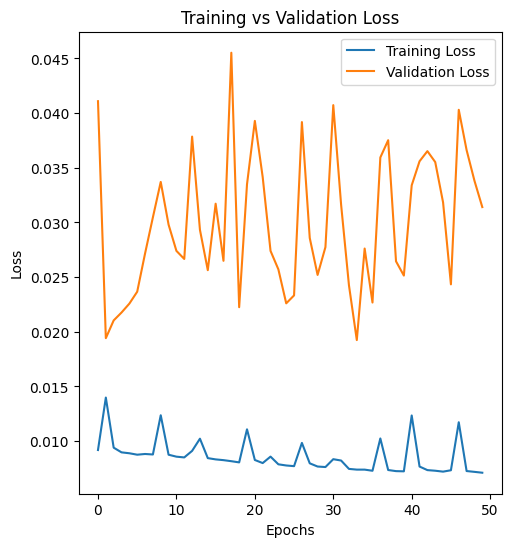

In [28]:
# Train the model
history = best_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
print(f"Evaluation of the model: ")
scores = best_model.evaluate(X_test, y_test)

# Access the F1 score for each category
f1_scores = scores[2:]  # Assuming they are the third metric onwards
print(f"F1 Scores for each category: {f1_scores}")

# Plot Training vs Validation Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [29]:
best_model.save(filepath='../models/nn_window.keras', overwrite=True, save_format='keras')

In [ ]:
loaded_model = tf.keras.models.load_model("model.keras")